In [1]:
import cppn
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
import torch
from torch import nn
import torchvision.models as models
import pytorch_ssim

from PIL import Image
import imageio
from IPython.display import display, clear_output
import time
from datetime import datetime
from tqdm import tqdm

In [2]:
class SaveOutput:
    def __init__(self):        
        self.outputs = []
        
    def __call__(self, module, module_in, module_out):
        self.outputs.append(module_out)
        
    def clear(self):
        self.outputs = []
        
class GramMatrix(nn.Module):
    def forward(self, input):
        b, c, h, w = input.size()
        f = input.view(b, c, h*w) #bxcx(hxw)
        # torch.bmm(batch1, batch2, out=None)
        # batch1 : bxmxp, batch2 : bxpxn -> bxmxn
        G = torch.bmm(f, f.transpose(1, 2)) # f: bxcx(hxw), f.transpose: bx(hxw)xc -> bxcxc
        return G.div_(h*w)

In [3]:
vgg19 = models.vgg19(pretrained=True)
vgg_readout = vgg19.features[:29].cuda()

save_output = SaveOutput()

feature_layers = [6, 11, 24]
content_layers = [20]
loss_layers = feature_layers + content_layers
# layer_weights = torch.from_numpy(np.multiply([1, 1, 1, 0.005], 1)).float().cuda()
layer_weights = torch.from_numpy(np.multiply([1, 1, 1, 1], 1)).float().cuda()
# feature_layers = [24]
hook_handles = []

for i, layer in enumerate(vgg_readout.modules()):
    if i in loss_layers:
        handle = layer.register_forward_hook(save_output)
        hook_handles.append(handle)

In [4]:
net_size = [128, 64, 32, 16, 16, 8] 
dim_z = 16
dim_c = 3
print(net_size)

G = cppn.CPPN(net_size, dim_z, dim_c).cuda()
sampler = cppn.Sampler(G)

[128, 64, 32, 16, 16, 8]


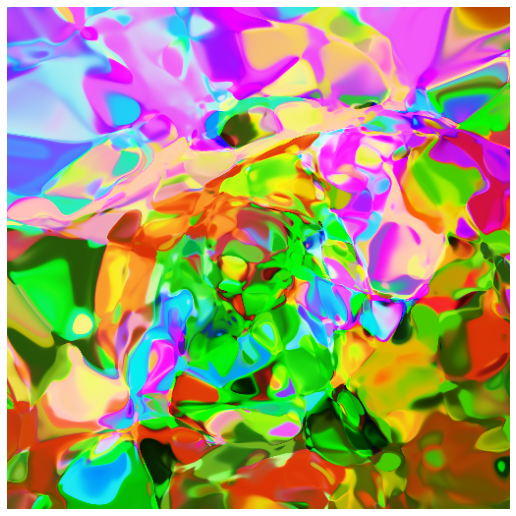

In [5]:
G.reinit(empty_cache=True)
gscale = 1
scale = 15
xres = 512
yres = 512
zscale = 4
nscale = 0

z =  torch.randn(1, dim_z).cuda()
delta_v = torch.randn(1, dim_z).cuda() 
z2 = z + 0.02*delta_v
coords = G._coordinates(scale*gscale,
                           xres, yres, z*zscale*gscale)

x = sampler.generate_img(G, z*zscale, scale, xres, yres, coords=coords)
sampler.imshow(x)

In [6]:
target_file = 'target/eye2.jpg'
img = Image.open(target_file)
shape = np.array(img).shape
aspectratio = shape[0] / shape[1]
XRES = 224
YRES = int( XRES * aspectratio )

TARGET = np.array(img.resize((XRES, YRES), Image.ANTIALIAS))
t_img = torch.from_numpy(TARGET).float().cuda().permute(2, 0, 1).unsqueeze(0).contiguous()
t_img = t_img / 255.0

optimImg = torch.autograd.Variable(t_img, requires_grad=True)
# optimImg = torch.autograd.Variable(torch.rand(size=t_img.shape).cuda(), requires_grad=True)
optimizer = torch.optim.LBFGS([optimImg])

In [7]:
with torch.no_grad():
    # style loss
    x = sampler.generate_img(G, z*zscale, scale, xres, yres, coords=coords, tensor=True)
    vgg_readout(x.permute(2, 0, 1).unsqueeze(0))
    targets = [GramMatrix()(o) for o in save_output.outputs]
    save_output.clear()
    
    # content loss
    vgg_readout(t_img)
    targets[-2] = GramMatrix()(save_output.outputs[-2])
    save_output.clear()
    


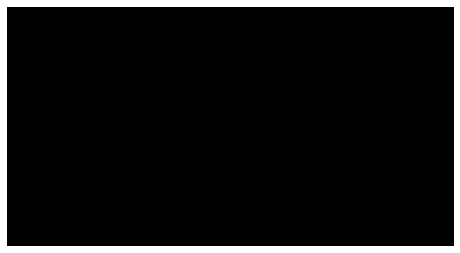

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

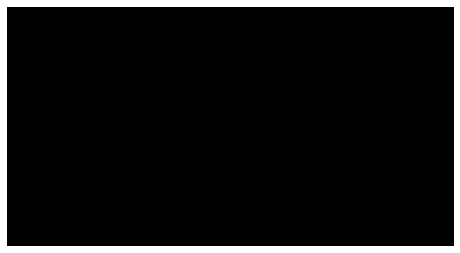

In [8]:
no_iter = 100

for iteration in range(1, no_iter):
    losses = []
    def cl():
        optimizer.zero_grad()
        vgg_readout(optimImg)
        out = save_output.outputs
        out_gram = [GramMatrix()(o) for o in out]
        losses = [nn.MSELoss()(out_gram[i], targets[i]) * layer_weights[i] for i in range(len(out_gram))]
        save_output.clear()
        totalLoss = sum(losses)
        totalLoss.backward()
        losses.append(totalLoss.item())
        return totalLoss
    optimizer.step(cl)
#     optimImg = torch.clip(optimImg.detach(),0, 255)

    if iteration%3 == 0:
        print('Iteration [%d]/[%d]'%(iteration,no_iter))
        
        nx = optimImg[0].detach().cpu().numpy().transpose(1, 2, 0)/255.0
        plt.clf()
        fig, axes = plt.subplots(1)
        axes.imshow(nx)
        axes.set_axis_off()
        plt.gcf().set_size_inches((8,8))
        clear_output(wait=True)
        display(plt.gcf())
        time.sleep(0.01)
    